时间序列介绍
时间序列(Time Series，TS)是数据科学中比较有意思的一个领域。顾名思义，TS是按固定时间间隔收集的数据点的集合。对这些数据进行分析以确定长期趋势，以便预测未来或执行其他形式的分析。但是TS又与常规回归问题不同。

- 它是时间相关的。因此，在这种情况下，“观测值是独立的线性回归模型”这个基本假设不成立。
- 随着趋势的增加或减少，大多数TS具有某种形式的季节性趋势，即特定时间范围内的变化。例如，一件羊毛夹克的销量，随着时间不断向前推进，我们会发现在冬季总是有更高的销量。


### 1.数据源基本操作

In [1]:
# 导入数据
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

data = pd.read_csv('./data/Sales.csv')
print(data.head())
data.dtypes

         日期   销量
0  20200101  237
1  20200102  243
2  20200103  257
3  20200104  254
4  20200105  246


日期    int64
销量    int64
dtype: object

In [2]:
from datetime import datetime 
dateparse = lambda dates: datetime.strptime(dates, '%Y%m%d')
# parse_dates=['日期'] 表示将'日期'列设置为时间类型
# index_col 将'日期'列设置为索引
data = pd.read_csv('./data/Sales.csv', parse_dates=['日期'],index_col='日期',date_parser=dateparse)
print('\n Parsed Data:')
print(data.head())



 Parsed Data:
             销量
日期             
2020-01-01  237
2020-01-02  243
2020-01-03  257
2020-01-04  254
2020-01-05  246


- parse_dates：指定包含时间信息的列。如上所述，列名称为“日期”。

- index_col：对TS数据使用Pandas的一个关键思想是索引必须是描述时间信息的变量。因此，此参数告诉Pandas使用“日期”列作为索引。

- date_parser：指定了一个将输入字符串转换为datetime变量的函数。默认情况下，Pandas读取格式为“ YYYY-MM-DD HH:MM:SS”的数据。如果数据不是这种格式，则必须手动定义格式。因此，可以使用类似于此处定义的dataparse函数的功能。


In [7]:
# 查看以时间为对象的索引
data.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23'],
              dtype='datetime64[ns]', name='日期', length=144, freq=None)

In [8]:
ts = data['销量']
ts.head(3)

日期
2020-01-01    237
2020-01-02    243
2020-01-03    257
Name: 销量, dtype: int64

In [9]:
# 通过索引，查看具体某天的销量情况
ts['2020-01-01']

237

In [10]:
# 查看两个日期之间所有的销量数据, 包含两端的两个日期
ts['2020-01-02':'2020-01-09']

日期
2020-01-02    243
2020-01-03    257
2020-01-04    254
2020-01-05    246
2020-01-06    260
2020-01-07    273
2020-01-08    273
2020-01-09    261
Name: 销量, dtype: int64

In [11]:
# 查看2020-01-08之前（包含1月8号这一天）所有的销量情况
ts[:'2020-01-08']

日期
2020-01-01    237
2020-01-02    243
2020-01-03    257
2020-01-04    254
2020-01-05    246
2020-01-06    260
2020-01-07    273
2020-01-08    273
Name: 销量, dtype: int64

In [ ]:
# 查看2020年1月份销量情况
ts['2020-01']

### 2.检测时间序列的平稳性
如果TS的统计特性（例如均值，方差）随时间保持恒定，则称TS是固定的。大多数TS模型都是在TS固定的前提下工作的。所以在一般情况下，我们可以认为，如果某个TS随时间具有特定的行为，那么将来很有可能会遵循相同的行为。而且，与非平稳序列相比，平稳序列有关的理论更加成熟并且更易于实现。

平稳性有着非常严格的标准定义。但是，出于实际考虑，如果该序列随时间具有不变的统计特性，则可以假定该序列是平稳的。本文提到的平稳性需满足：

- 恒定均值
- 恒定方差
- 不依赖时间的自协方差


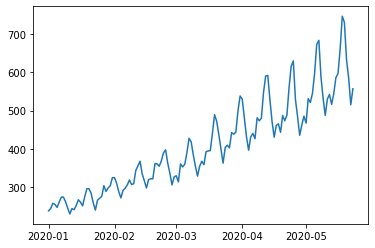

In [12]:
# 原始销量变化趋势图
plt.plot(ts)

显然，数据总体上呈上升趋势，并且存在一些季节性变化。但是，这种视觉推断并不总是准确的。因此，我们会使用以下方法检查平稳性：

- 绘制移动统计数据：通过绘制移动平均值或移动方差趋势图，判断其是否随时间变化。
- Dickey-Fuller检验：这是用于检查平稳性的统计检验之一。这里的零假设是TS是非平稳的。测试结果包括测试统计量和一些差异置信度的临界值。如果“检验统计量”小于“临界值”，我们可以拒绝原假设并说该序列是平稳的。


In [ ]:
# 安装statsmodels
!pip install statsmodels

In [16]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
    #Determing rolling statistics 
    rolmean = timeseries.rolling(window=12).mean() # 移动均值
    rolstd = timeseries.rolling(window=12).std() # 移动方差
    
    #Plot rolling statistics 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red',label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print(dfoutput)
    
    
    
    

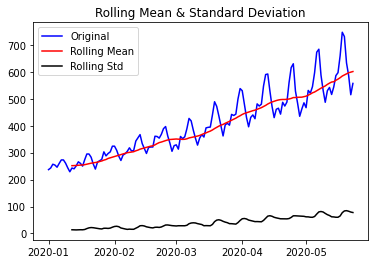

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(ts)

尽管标准差(Rolling Std)变化很小，但均值(Rolling Mean)显然随时间增加，这并不是平稳序列。测试统计数据也不仅是含有临界值。注意：应该连同符号比较，而不是绝对值。

### 3.如何使时间序列平稳
尽管在许多TS模型中都采用了平稳性假设，但实际的时间序列几乎没有一个是平稳的。所幸我们已经找到了一些使时间序列平稳的方法。实际上，要使一个时间序列完全固定几乎是不可能的，但是我们尝试使其尽可能接近平稳。

导致TS不平稳的背后原因主要有两个：

1. 趋势——均值随时间变化。例如，乘客数量随时间增长。
2. 季节性——在特定时间范围内的变化。例如，由于加薪或节日的影响，人们可能会在特定月份购买汽车。

**基本原理**是对时间序列中的趋势和季节性建模或估计，并将其从序列中删除以得到固定的时间序列。然后在该时间序列上实施统计预测技术。最后一步则是通过应用趋势和季节性约束将预测值转换为原始比例。

下面会讨论多种方法。有的可能效果很好，而有的可能效果不好。但是，我们的目的是掌握所有的方法，而不是仅仅关注眼前的问题。


#### 3.1 估计和消除趋势
##### 3.1.1 对数转换
减小趋势的常用技巧是转换。例如，在上文原始数据趋势图中，我们可以清楚地看到存在明显的上升趋势。因此，我们可以应用变换来惩罚较高的值。可以取对数，平方根，立方根等。为简单起见，在这里进行对数转换（注意下图中纵坐标的变化）。

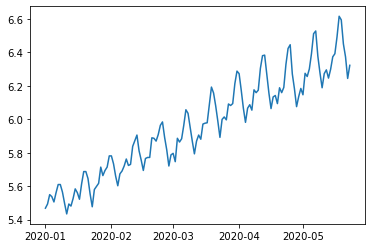

In [18]:
ts_log = np.log(ts)
plt.plot(ts_log)

在这种简单的情况下，很容易看到数据中的向前趋势。但是在有噪音的情况下它不是很直观。因此，我们可以先使用一些技术来估算或建模，然后将其从序列中消除。常用的方法有：

- 聚类。在一段时间内取平均值，例如每月/每周平均值。
- 平滑。取滑动平均值
- 多项式拟合。拟合回归模型。

##### 3.1.2 移动平均
根据时间序列的频率取K个连续值的平均值，假设K=12,即最近12天的数据

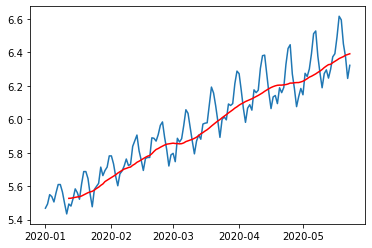

In [19]:
moving_avg = ts_log.rolling(12).mean() 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

红线表示移动平均值。我们把它从原始时间序列中减去。并且，由于我们取的是最近12个值的平均值，因此前11个值没有定义移动平均值。

In [20]:
ts_log_moving_avg_diff = ts_log - moving_avg 
ts_log_moving_avg_diff.head(15)

日期
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
2020-01-09         NaN
2020-01-10         NaN
2020-01-11         NaN
2020-01-12   -0.033685
2020-01-13   -0.047156
2020-01-14   -0.005041
2020-01-15    0.050134
Name: 销量, dtype: float64

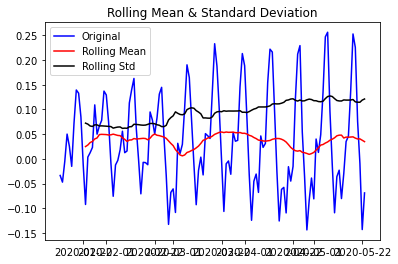

Results of Dickey-Fuller Test:
Test Statistic                  -3.518434
p-value                          0.007526
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [21]:
#删除NAN值，再检查平稳性
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

名词解释:

Dickey-Fuller 迪基-福勒检验, 单位根检验, 如果存在时序数据中存在单位根, 则表明是非平稳序列

ADF检验 增广迪基-福勒检验 排除了自相关的影响

为什么需要检验:

单位根检验师时序序列分析的一个热点问题, 大部分时序模型都要求输入数据具有稳定性, 因此要先检测数据是否稳定.

如果数据本身是不稳定的, 要对数据做差分变化等操作消除单位根, 此时目标值已经没有了实际含义, 但是满足模型需求, 结果在逆向推导.

检验原理:

时序回归方程: x_t = k *(x_t -1) + b.

B为一系列平稳噪音,

|K|<1, 当k为1时, 上式就是一个随机游走(时序前后毫无关系)序列, 一种单位根过程.

上式可以转化为: (1-kL)x_t = b , 当k=1时, 存在单位根.

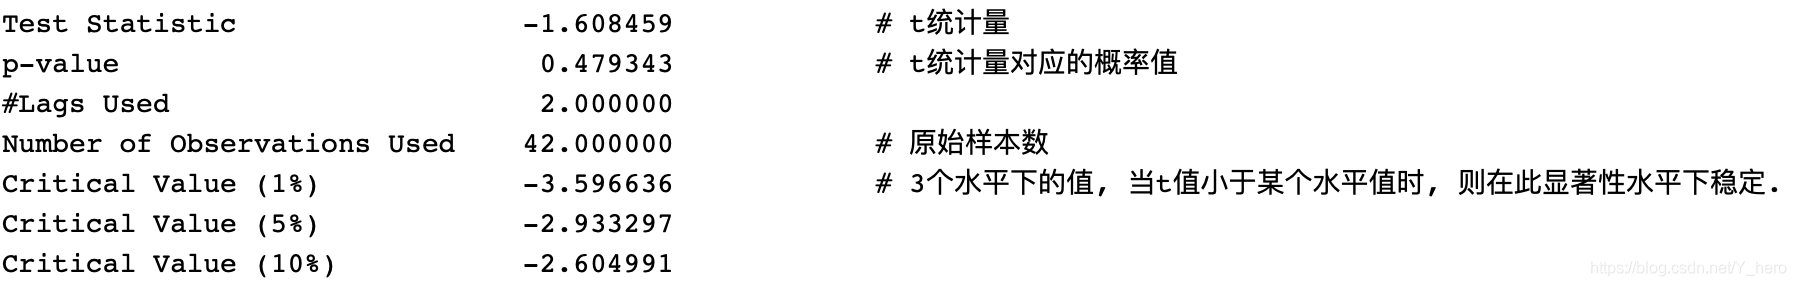

<strong><font color=red>用p-value 和 0.05 比较，如果p-value >0.05 则表示非平稳， 如果 p<0.05 则大概率表示为平稳序列</font></strong>

测试统计量小于5％的临界值，因此我们可以以95％的置信度说这是一个平稳的序列。在这种情况下，不会遗漏任何值，因为从一开始所有的值都被赋予了权重。因此，即使没有先前的值也可以使用。

#### 3.2 消除趋势和季节性
前面讨论的简单趋势减少技术并不能在所有情况下都有效，尤其是季节性高的情况下。接下来讨论消除趋势和季节性的两种方法：

- 差异化：以特定的时间差来差异化。
- 分解：对趋势和季节性建模，并将其从模型中删除。

##### 3.2.1 差异化
将特定时刻的观测值与前一时刻的观测值进行了差异。这在改善平稳性方面效果很好。此处使用一次偏移进行差异化。

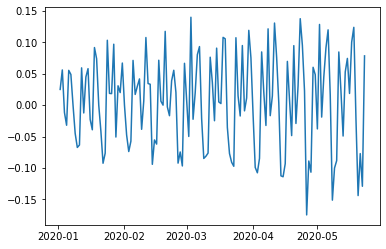

In [23]:

ts_log_diff = ts_log -ts_log.shift() 
plt.plot(ts_log_diff)

移动是指沿着时间轴方向将数据进行前移或后移。Pandas对象中提供了一个shift()方法，用来前移或后移数据，但索引保持不变。shift()方法语法格式如下：shift(periods=1，freq=None，axis=0)

部分参数含义如下：

periods：表示移动的幅度，可以为正数，也可以为负数，默认值是1，代表移动一次。

freq：如果这个参数存在，那么会按照参数值移动时间戳索引，而数据值没有发生变化

time_ser.shift(periods=1)          #正数向后移动,数据向下移动,向未来日期移动,没有数据的日期变成 NaN

time_ser.shift(periods=-1)          #负数向前移动,数据向上移动,向过去日期移动,没有数据的日期变成 NaN

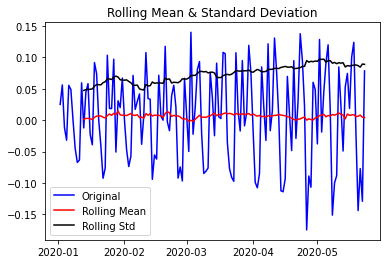

Results of Dickey-Fuller Test:
Test Statistic                  -3.423486
p-value                          0.010184
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [24]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

可以看到，均值和标准差随时间变化很小。而且，Dickey-Fuller测试统计量小于5％临界值，因此TS处于95％置信度。我们还可以采用二次或三次偏移，这在某些场景下可能会获得更好的结果。

##### 3.2.2 分解
这种方法对趋势和季节性分别建模，然后返回序列的残余部分

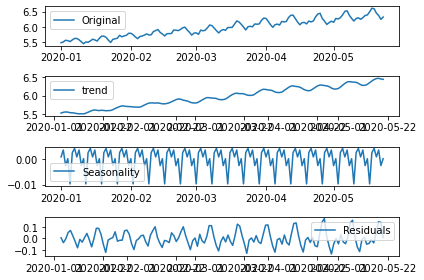

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

可以看到趋势，季节性和数据已分离，并且可以对残差进行建模。我们再次检查残差的平稳性：

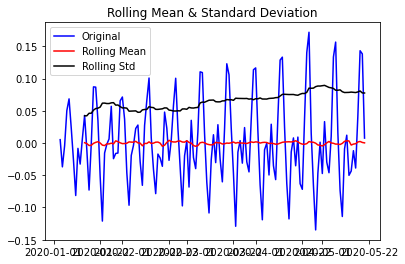

Results of Dickey-Fuller Test:
Test Statistic                  -4.628131
p-value                          0.000115
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [28]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Dickey-Fuller检验统计量明显低于1％临界值。因此，此TS非常接近固定位置。也可以尝试使用高级分解技术，以产生更好的结果。应该注意的是，在这种情况下，将残差转换为原始数据以用于将来的数据不是很直观。

### 时间序列预测
上面谈到的这些不同的技术都可以使TS趋于平稳。现在让我们在差分后的TS上建立模型。这是一种非常流行的技术，并且在这种情况下，将噪声和季节性重新添加到预测残差中相对较容易。执行了趋势和季节性估计技术后，可能出现两种情况：

1. 在数值之间没有相关性的一个严格的平稳序列。这是简单的情况，其中我们可以将残差建模为白噪声，但这是非常罕见的。

2. 数值之间有重大依赖性的时间序列。在这种情况下，我们需要使用ARIMA之类的统计模型来预测数据。

ARIMA，即自回归移动平均模型，对平稳时间序列的预测只是一个线性(如线性回归)方程。预测变量取决于ARIMA模型的参数(p，d，q):

1. AR(Auto-Regressive，自回归)项的数量（p）：AR项是因变量的滞后值。例如，如果p为5，则x(t)的预测变量为x(t-1)…x(t-5)。

2. MA(Moving Average，移动平均)项的数量（q）： MA项是预测方程式中的滞后预测误差。例如，如果q为5，则x(t)的预测变量将为e(t-1)….e(t-5)，其中e(i)是第i个瞬时移动平均值与实际值之间的差。

3. 差异数（d）：这些是非季节性差异数，即在这种情况下，我们采用一阶差分。因此，我们可以传递该变量并置d = 0，或者传递原始变量并置d = 1。两者都会产生相同的结果。

如何确定“ p”和“ q”的值呢？

1. 自相关函数(Autocorrelation Function，ACF)：它是TS与自身滞后版本之间的相关性的度量。例如，在滞后值为5，ACF会将时间点“t(1)”…“t(2)”处的序列与时间点“t(1)-5”……“ t(2)-5”处的序列进行比较。

2. 局部自相关函数(Partial Autocorrelation Function，PACF)：此方法在消除了TS与自身滞后版本之间的比较差异后，测量二者的相关性。例如，它将检查滞后值为5的相关性，但删除滞后值为1到4的影响。


In [31]:
# 差分后，绘制TS的ACF和PACF图。
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf 

lag_acf = acf(ts_log_diff, nlags=20,fft=False)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

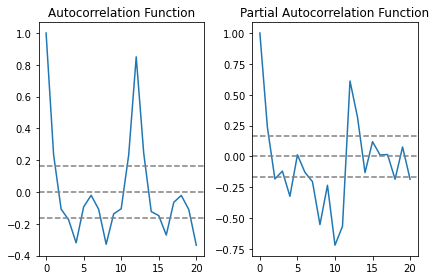

In [32]:
# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle="--",color="gray")
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

在上图中，0两侧的两条虚线是置信区间，可用于确定“p”和“q”值，如下所示：

- p – PACF的滞后值图表首次超过上限置信区间。如果密切注意，在这种情况下，p = 2。
- q – ACF图表首次超过上限置信区间的滞后值。如果您密切注意，在这种情况下，q = 2。

<strong>上面这个是怎么确定是2的？ 还没有搞清楚</strong>

下面3个不同的ARIMA模型，将分别考虑单独情况和综合情况，并输出RSS。这里的RSS是指残差值，而不是实际的序列。

In [47]:
from statsmodels.tsa.arima_model import ARIMA 

### AR Model

Text(0.5, 1.0, 'RSS:0.6780')

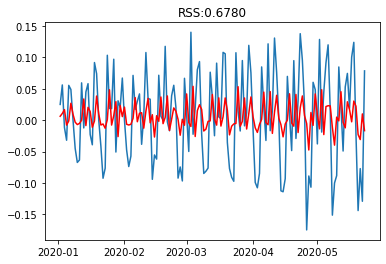

In [52]:
model = ARIMA(ts_log, order=(2,1,0),freq='D')
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS:%.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model 

Text(0.5, 1.0, 'RSS:0.6674')

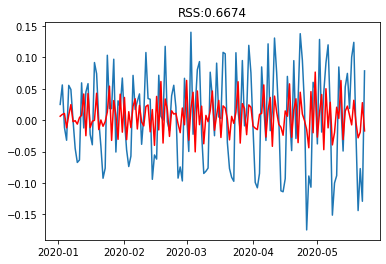

In [55]:
model=ARIMA(ts_log, order=(0,1,2),freq='D')
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS:%.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined Model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'RSS:0.4507')

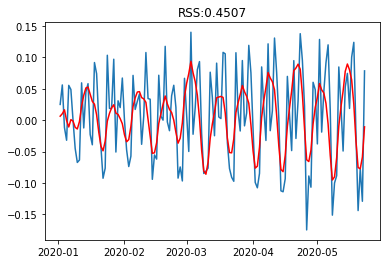

In [66]:
model = ARIMA(ts_log, order=(2,1,2), freq='D')
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS:%.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

可以看到AR和MA模型具有几乎相同的RSS，但结合起来明显更好。现在，最后一个步骤，即将这些值恢复为原始比例

### 恢复到原始比例
由于组合模型提供了最佳结果，因此我们将其缩放回原始值并查看其在该位置的性能如何。第一步是将预测结果存储为单独的序列并进行观察。

In [67]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

日期
2020-01-02    0.006307
2020-01-03    0.010219
2020-01-04    0.016415
2020-01-05   -0.000640
2020-01-06   -0.010863
dtype: float64

这些日期从“2020-01-02”开始，而不是“2020-01-01”。因为我们的延迟为1，并且第一个元素之前没有要减去的元素。将差异转换为对数刻度的方法是将这些差异连续添加到基数中。一种简单的方法是先确定索引处的累加和，然后将其加到基数上。累积总和可以找到为：

In [68]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

日期
2020-01-02    0.006307
2020-01-03    0.016526
2020-01-04    0.032940
2020-01-05    0.032300
2020-01-06    0.021437
dtype: float64

接下来，需要将它们添加到基数中。为此，我们创建一个以所有值为基数的序列，并在其中添加差异。在这里，第一个元素是基数本身，并从此开始累加值。

In [69]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

日期
2020-01-01    5.468060
2020-01-02    5.474367
2020-01-03    5.484586
2020-01-04    5.501000
2020-01-05    5.500360
dtype: float64

最后一步是利用指数将其还原成原始比例，并与原始序列进行比较。
查看最终的预测结果

Text(0.5, 1.0, 'RMSE:56.0520')

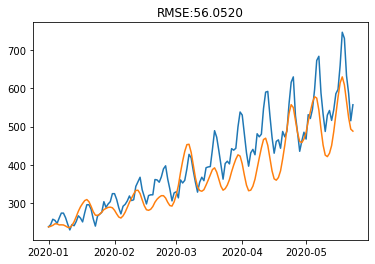

In [74]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE:%.4f'% np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

# 概念补充

什么是ACF, PACF?

ACF 定义: 是衡量$y_t和y_{t-k}$间的相关性

PACF定义: 是在去除$y_{t-1},y_{t-2},...,y_{t-k+1}$等的影响后，衡量$y_t和y_{t-k}$之间的相关性

有关ACF, PACF的概述  

ACF 是一个完整的自相关函数，可为我们提供具有滞后值的任何序列的自相关值。简单来说，它描述了该序列的当前值与其过去的值之间的相关程度。时间序列可以包含趋势，季节性，周期性和残差等成分。ACF在寻找相关性时会考虑所有这些成分。

<strong>直观上来说，ACF 描述了一个观测值和另一个观测值之间的自相关，包括直接和间接的相关性信息。</strong>

PACF 是部分自相关函数或者偏自相关函数。基本上，它不是找到像ACF这样的滞后与当前的相关性，而是找到残差（在去除了之前的滞后已经解释的影响之后仍然存在）与下一个滞后值的相关性。因此，如果残差中有任何可以由下一个滞后建模的隐藏信息，我们可能会获得良好的相关性，并且在建模时我们会将下一个滞后作为特征。请记住，在建模时，我们不想保留太多相互关联的特征，因为这会产生多重共线性问题。因此，我们只需要保留相关功能。

直观上来说，PACF 只描述观测值$y_t$和其滞后项$y_{t-k}$之间的直接关系，调整了其他较短滞后项($y_{t-1},y_{t-2},...,y_{t-k+1}$)的影响。


模型选择

|模型|ACF|PACF|
|---|---|---|
|AR(p)|拖尾|P阶截尾|
|MA(q)|q阶截尾|拖尾|
|ARMA(p,q)|拖尾|拖尾|

什么是截尾，拖尾?
- 截尾：在大于某个常数k后快速趋于0为k阶截尾
- 拖尾：始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动)

什么是白噪声?

什么是随机游走?

$X_t$